<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy

In [ ]:
!git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

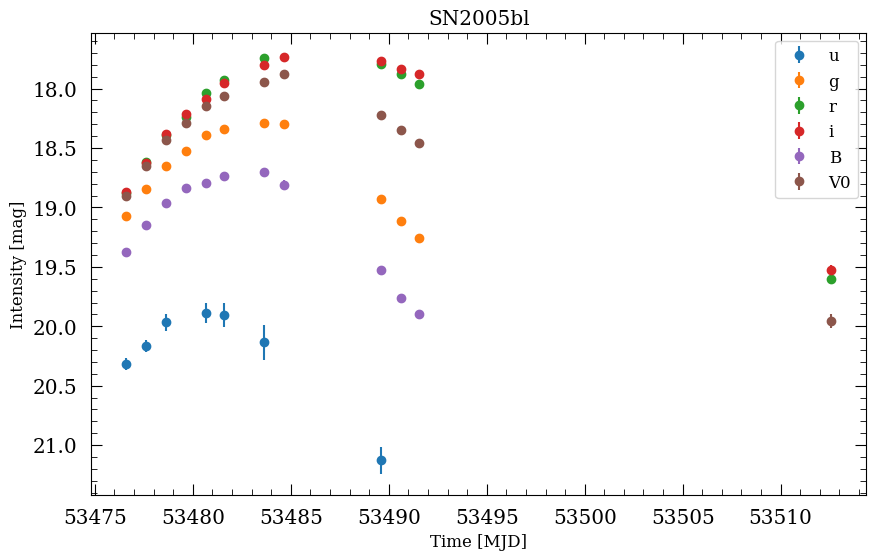

In [14]:
"""
Plotting 91bg like 1a to get an idea of what they look like
"""
import matplotlib.pyplot as plt
import numpy as np

FILTER_WHEEL = ['u', 'g', 'r', 'i', 'B', 'V0']

if __name__ == '__main__':
    KrisciunasPath = "/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt"
    KrisciunasNames = np.genfromtxt(KrisciunasPath, dtype=str, delimiter=', ')

    allCPSPhot = "/content/HiloCATsSN1991bg/data/CSPdata/SN_photo.dat"
    allCPSPhotData = np.genfromtxt(allCPSPhot, dtype='str')

    names = allCPSPhotData[:,0]
    filters = allCPSPhotData[:,1]
    time = allCPSPhotData[:,2]
    light = allCPSPhotData[:,3]
    err = allCPSPhotData[:,4]

    plt.figure(figsize=(10,6))
    sigma = 1
    for tar in KrisciunasNames:
        for n in range(len(FILTER_WHEEL)):
            # output_names = names[(names == tar) & (filters == FILTER_WHEEL[n])]
            output_light = light[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            output_time = time[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64') + 53000
            output_err = err[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            plt.errorbar(output_time, output_light, yerr=output_err*sigma, fmt='o', label=FILTER_WHEEL[n])

        plt.title(tar); plt.xlabel('Time [MJD]'); plt.ylabel('Intensity [mag]')
        plt.gca().invert_yaxis()
        plt.legend()
        # plt.savefig('save\\'+str(tar)+'.png')
        plt.show()
        break


Fiting data for SN2005bl...
--------------------------------------------------------------------------------
SN  SN2005bl
z = 0.0241          ra=181.05108         dec= 20.40689 
Data in the following bands: u,  g,  r,  i,  B,  V0,  
Fit results (if any):
   DM = 36.091  +/-  0.179  +/- 0.220 (sys)
   st = 1.317  +/-  0.158  +/- 0.030 (sys)
   EBVhost = 0.803  +/-  0.149  +/- 0.060 (sys)
   Tmax = 482.634  +/-  1.314  +/- 0.340 (sys)


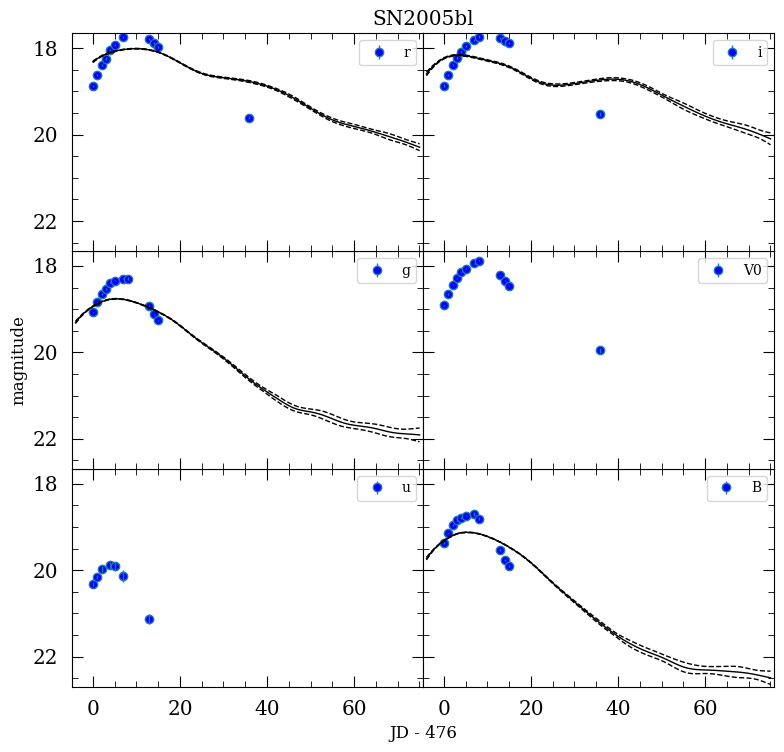

In [6]:
"""
SNooPy fitting on CSP data
"""
import matplotlib.pyplot as plt
import numpy as np
import snpy

def snpy_fit(filePath, model='max_model', shapeParam='dm15', BandsToFit = ['B','g','r','i'], summarize=True):
    s = snpy.get_sn(filePath)

    # Set model parameters
    s.choose_model(model, stype=shapeParam)
    s.set_restbands() # Auto pick appropriate rest-bands

    # Fit data -- using David configurations
    fitargs = {'mangle':1,'calibration':0} # I don't remember what calibration is
    s.fit(BandsToFit,
          dokcorr=True,
          k_stretch=False,
          reset_kcorrs=True,
          **fitargs)

    # Show results
    if summarize:
        s.summary()
        # for param in s.parameters:
        #     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))
    return

if __name__ == '__main__':
    # Initalize File -- SN2005ke
    KrisciunasNames = np.genfromtxt("/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt", dtype=str, delimiter=', ')
    filePaths = []
    for tar in KrisciunasNames:
        filePaths.append('/content/HiloCATsSN1991bg/data/CSPdata/'+str(tar)+'_snpy.txt')

    # Enter snpy fit function
    # for n in range(len(filePaths)):
    #     print('Fiting data for '+filePaths[n][39:47]+'...')
    #     try:
    #         snpy_fit(filePaths[n], model='EBV_model2', shapeParam='st', BandsToFit = ['B','g','r','i'], summarize=False)
    #     except:
    #         print('FAILED, '+str(n))
    n = 0
    print('Fiting data for '+filePaths[n][39:47]+'...')
    snpy_fit(filePaths[n], model='EBV_model2', shapeParam='st', BandsToFit = ['B','g','r','i'], summarize=True)

